Hello! In this notebook, I'll be tackling the Kaggle Butterflies and Moths fieldguide challenge. https://www.kaggle.com/c/fieldguide-challenge-moths-and-butterflies/. My model is a bit of a Frankenstein adapted from various ResNet tutorials I've found, but it works very well!

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from matplotlib import pyplot
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.utils.vis_utils import model_to_dot
#from tensorflow.keras.utils import plot_model
#from resnets_utils import *
from tensorflow.keras.initializers import HeNormal


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

with open('/home/garrett/KagglesData/Butterflies/fgvc_fg_training.json','r') as anno_train:
    train = json.load(anno_train)
with open('/home/garrett/KagglesData/Butterflies/fgvc_fg_testing.json','r') as anno_test:
    test = json.load(anno_test)

#print(train)   


train.keys()
test.keys()
test_df = pd.DataFrame()
test_df = test_df.append(test['images'], ignore_index=True)
train_df = pd.DataFrame()
train_df = train_df.append(train['images'], ignore_index=True)
train_df_anno = pd.DataFrame()
train_df_anno = train_df_anno.append(train['annotations'], ignore_index=True)
train_df['category_id'] = train_df_anno['category_id'].astype('str')
test_df = test_df.append(test['images'], ignore_index=True)
test_df_anno = pd.DataFrame()

train_df = train_df.drop(['id', 'width', 'height', 'url', 'license'], axis = 1)
test_df = test_df.drop(['id', 'width', 'height', 'url', 'license'], axis = 1)

print(train_df.head())


foldertrain = '/home/garrett/KagglesData/Butterflies/data-images/training/images/'
foldertest = '/home/garrett/KagglesData/Butterflies/data-images/testing/images/'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10942140073906975448
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4291362816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4998471419318289652
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
                              file_name category_id
0  0000031e2e9701e24d046c0dc3889bde.jpg         578
1  00001246ce7f88ec292384abcc58d3e0.jpg         438
2  00006fd6c3cd2e525e2df491e157844d.jpg        3990
3  0000a8ef4598a73544df0d42ca754a73.jpg        2964
4  0000d2de78907e422f61ec502819e27b.jpg        1757


In [2]:
def LookAtRawImages(df, folder, isTrain, slicesize=1000):
    #start with only a small dataset, to make sure the network architecture is ok
    for i in range(slicesize):
        # define subplot
        # define filename
        filename = folder + df.at[i, 'file_name']
        # load image pixels. Images are rgb
        image = imread(filename)
        imresize = cv2.resize(image, (600,600),interpolation = cv2.INTER_AREA)
        #plot raw rgb pixel data
        #images.append(imresize)
        if(i%100 == 0):
            print("got image "+str(i)),
            pyplot.imshow(imresize)
            # show the figure
            pyplot.show()
            if isTrain == 1:
                cat_label = df.at[i,'category_id']
                print(cat_label)
            
    return

got image 0


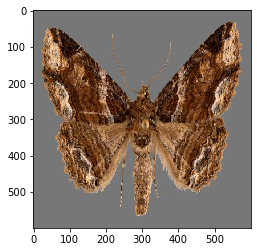

578
got image 100


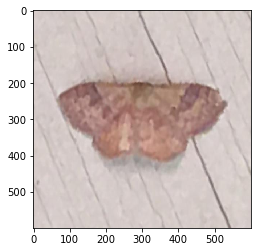

4352
got image 200


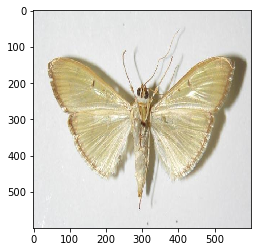

489
got image 300


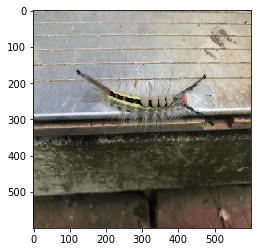

5335
got image 400


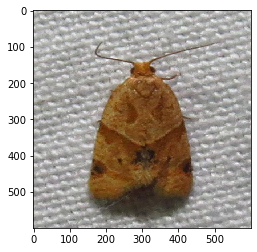

4734
got image 500


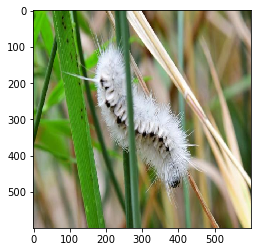

4769
got image 600


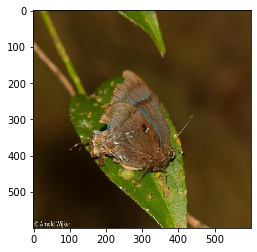

259
got image 700


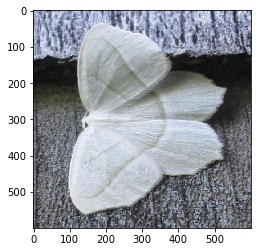

5245
got image 800


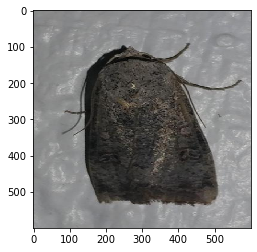

488
got image 900


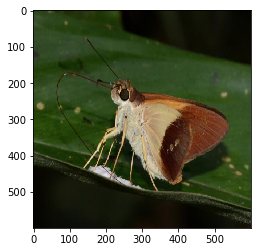

3358


In [8]:
LookAtRawImages(train_df, foldertrain, 1)

The raw images don't look like they need much more preprocessing, beyond normalizing them. Let's flow from the file to save memory.

In [3]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=foldertrain,
    x_col="file_name",
    y_col="category_id",
    subset="training",
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes = [str(x) for x in range(5419)],
    target_size=(600,600))

valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=foldertrain,
    x_col="file_name",
    y_col="category_id",
    subset="validation",
    batch_size=10,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes = [str(x) for x in range(5419)],    
    target_size=(600,600))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=foldertest,
x_col="file_name",
y_col=None,
batch_size=10,
seed=42,
shuffle=False,
class_mode=None,
target_size=(600,600))

Found 355079 validated image filenames belonging to 5419 classes.
Found 118359 validated image filenames belonging to 5419 classes.
Found 118282 validated image filenames.


In [11]:
#Now we build the basic Convnet. Use Tensorflow + Keras for this on my RTX gpu.
#Let's make a ResNet from scratch in Keras. First, define the basic residual layer.

def identity_block(X, f, filters, stage, block):
    
    # defining name basis
    cNN_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Get filters, save input
    F1, F2, F3 = filters
    X_forlater = X
    
    # First CNN, batchnorm, and RELU. Use He normal init for the CNN layers.
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = cNN_name_base + '2a', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second CNN, batchnorm, and RELU.
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = cNN_name_base + '2b', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third CNN and batchnorm
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = cNN_name_base + '2c', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add original X to main path, and pass it through a RELU activation
    X = Add()([X, X_forlater])
    X = Activation('relu')(X)
    
    
    return X

In [13]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_forlater = X

    # First CNN, batchnorm, and RELU. Use He normal init for the CNN layers.

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second CNN, batchnorm, and RELU. Use He normal init for the CNN layers and ELU activation.
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third CNN, batchnorm, and RELU. Use He normal init for the CNN layers and ELU activation.
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X_forlater = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = HeNormal())(X_forlater)
    X_forlater = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_forlater)

    
    # Final step: Add original X to main path, and pass it through a RELU activation
    X = Add()([X, X_forlater])
    X = Activation('relu')(X)
    
    return X

Now let's make the model! I'm only going to do a few filters here, so I don't necessarily expect this to be the most accurate- my GPU doesn't have the memory to hold too much. Once I get some spare time, I may try to run this on CoLab so I can make a bigger model.

In [15]:
def ResNet(input_shape=(600, 600, 3), classes=5419):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=HeNormal())(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[4, 4, 16], stage=2, block='a', s=1)
    X = identity_block(X, 3, [4, 4, 16], stage=2, block='b')
    X = identity_block(X, 3, [4, 4, 16], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [8, 8, 32], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [8, 8, 32], stage=3, block='b')
    X = identity_block(X, 3, [8, 8, 32], stage=3, block='c')
    X = identity_block(X, 3, [8, 8, 32], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [16, 16, 64], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [16, 16, 64], stage=4, block='b')
    X = identity_block(X, 3, [16, 16, 64], stage=4, block='c')
    X = identity_block(X, 3, [16, 16, 64], stage=4, block='d')
    X = identity_block(X, 3, [16, 16, 64], stage=4, block='e')
    X = identity_block(X, 3, [16, 16, 64], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [32, 32, 128], stage=5, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = HeNormal())(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNetSmall')

    return model

In [16]:
#import tensorflow.keras.backend as K
#K.clear_session()

In [17]:
model= ResNet(input_shape=(600, 600, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Interestingly, with Glorot uniform init instead of He Normal and ELU instead of RELU, the network trains much faster but fails to learn (loss does not decrease on train or test sets). Given the general similarity of RELU and ELU, I'd posit that the difference is Glorot uniform vs He normal. After four straight days of training, the network still hasn't converged, so we know it's working, but it would be great to run some larger batches!

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5)

Epoch 1/5
35507/35507 [==============================] - 64859s 2s/step - loss: 7.2477 - accuracy: 0.0486 - val_loss: 6.5704 - val_accuracy: 0.0801
Epoch 2/5
35507/35507 [==============================] - 55178s 2s/step - loss: 6.0864 - accuracy: 0.1211 - val_loss: 5.9101 - val_accuracy: 0.1440
Epoch 3/5
35507/35507 [==============================] - 62910s 2s/step - loss: 5.0982 - accuracy: 0.1987 - val_loss: 5.5090 - val_accuracy: 0.1918
Epoch 4/5
35507/35507 [==============================] - 51424s 1s/step - loss: 4.1213 - accuracy: 0.2825 - val_loss: 6.0411 - val_accuracy: 0.1844
Epoch 5/5
35507/35507 [==============================] - 66702s 2s/step - loss: 3.2833 - accuracy: 0.3810 - val_loss: 5.7866 - val_accuracy: 0.2186


In [20]:
model.save("SmallResNet")

/home/garrett/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: SmallResNet/assets


In [23]:
print('\n# Generate top 3 predictions for test set')
predictions = model.predict(test_generator)


print('predictions shape:', predictions.shape)
predvals = tf.math.argmax(predictions, axis = 1)
print(predvals)


# Generate top 3 predictions for test set


ResourceExhaustedError:  OOM when allocating tensor with shape[10,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node ResNetSmall/bn_conv1/FusedBatchNormV3 (defined at <ipython-input-23-82e31b2f741e>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_530179]

Function call stack:
predict_function
